In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,precision_score,roc_auc_score,f1_score,classification_report

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler,OneHotEncoder, FunctionTransformer

import mlflow
import pickle

In [4]:
df=pd.read_csv('data/train.csv')

num_cols=['person_age','person_income','person_emp_length','loan_amnt','loan_int_rate','loan_percent_income','cb_person_cred_hist_length','person_home_ownership','loan_grade','cb_person_default_on_file']
cat_cols=['loan_intent']
logtrans_feats=['person_age','person_income','person_emp_length','loan_amnt','loan_percent_income','cb_person_cred_hist_length']

X=df.drop(columns=['id','loan_status'])
y=df['loan_status']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)


In [5]:

loangrade_map={'A':1,'B':2,'C':3,'D':4,'E':5,'F':6,'G':7}
persondefault_map={'N':0,'Y':1}
homeownership_map={'OTHER':0,'RENT':1,'MORTGAGE':2,'OWN':3}

def custom_ordinalencoding(df):
    df['loan_grade']=df['loan_grade'].replace(loangrade_map)
    df['cb_person_default_on_file']=df['cb_person_default_on_file'].replace(persondefault_map)
    df['person_home_ownership']=df['person_home_ownership'].replace(homeownership_map)

    return df

X_train=custom_ordinalencoding(X_train)

coltrans1=ColumnTransformer(transformers=[
    ('LogTransform',FunctionTransformer(np.log1p,feature_names_out='one-to-one'),logtrans_feats),
],verbose_feature_names_out=False,remainder='passthrough')
# coltrans1.set_output(transform='pandas')

num_pipeline=Pipeline(steps=[
    ('logtrans',coltrans1),
    ('impute',SimpleImputer(strategy='mean')),
    ('scale',StandardScaler())
])

cat_pipeline=Pipeline(steps=[
    ('onehot',OneHotEncoder(handle_unknown='ignore',drop='first')),
    ('impute',SimpleImputer(strategy='most_frequent'))
])

coltrans2=ColumnTransformer(transformers=[
    ('NumericalPipeline',num_pipeline,num_cols),
    ('CategoricalPipeline',cat_pipeline,cat_cols)
],verbose_feature_names_out=False)

X_train=coltrans2.fit_transform(X_train)
X_train=pd.DataFrame(X_train,columns=coltrans2.get_feature_names_out())

X_test=custom_ordinalencoding(X_test)
X_test=coltrans2.transform(X_test)

X_train.head()


,person_age,person_income,person_emp_length,loan_amnt,loan_percent_income,cb_person_cred_hist_length,loan_int_rate,person_home_ownership,loan_grade,cb_person_default_on_file,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE
0,1.772397,-1.503737,-0.486347,-0.320903,0.699095,1.785884,1.266305,-0.882534,1.838894,-0.419473,0.0,0.0,1.0,0.0,0.0
1,0.875912,0.496622,-0.117396,1.495015,1.220441,1.192421,0.779504,-0.882534,0.885332,-0.419473,0.0,0.0,1.0,0.0,0.0
2,-0.833049,-0.343720,0.168785,-0.661815,-0.644841,-0.743218,0.920939,-0.882534,0.885332,2.383944,1.0,0.0,0.0,0.0,0.0
3,-0.403505,0.526735,1.057744,-0.253650,-0.763379,-0.743218,1.203810,-0.882534,0.885332,2.383944,1.0,0.0,0.0,0.0,0.0
4,-0.403505,0.726638,0.771563,0.700226,-0.067867,-0.743218,-0.023058,0.784400,-0.068231,-0.419473,0.0,1.0,0.0,0.0,0.0


In [6]:
from imblearn.over_sampling import SMOTE

sm=SMOTE(random_state=6)

X_train_sm,y_train_sm=sm.fit_resample(X_train,y_train)
y_train_sm.value_counts()

loan_status
1    40154
0    40154
Name: count, dtype: int64

In [7]:

mlflow.set_experiment('LoanApp')

with mlflow.start_run():
    logreg=LogisticRegression().fit(X_train_sm,y_train_sm)

    tr_pred=logreg.predict(X_train)
    te_pred=logreg.predict(X_test)

    clfrep_train=classification_report(y_train,tr_pred)
    clfrep_test=classification_report(y_test,te_pred)
    
    tr_acc=accuracy_score(y_train,tr_pred)
    tr_prec=precision_score(y_train,tr_pred)
    tr_f1=f1_score(y_train,tr_pred)
    tr_aucroc=roc_auc_score(y_train,tr_pred)

    te_acc=accuracy_score(y_test,te_pred)
    te_prec=precision_score(y_test,te_pred)
    te_f1=f1_score(y_test,te_pred)
    te_aucroc=roc_auc_score(y_test,te_pred)

    print('Train report')
    print(clfrep_train)

    print('Test rep')
    print(clfrep_test)

    metric_names=['f1','auc roc']
    tr_values=[tr_f1,tr_aucroc]
    te_values=[te_f1,te_aucroc]

    for inx,metname in enumerate(metric_names):
        mlflow.log_metric(' '.join(['tr',metname]),tr_values[inx])
        mlflow.log_metric(' '.join(['te',metname]),te_values[inx])

    print(te_values)

    mlflow.set_tag('model prop','Base logreg with SMOTE')


model_pkl_file='outputs/loanapp_logreg.pkl'
with open(model_pkl_file, 'wb') as file:  
    pickle.dump(logreg, file)

coltrans_pkl_file = "outputs/loanapp_coltransformer.pkl"  

with open(coltrans_pkl_file, 'wb') as file:  
    pickle.dump(coltrans2, file)

2024/10/10 18:01:08 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh(<full-path-to-git-executable>)

All git commands will error until this is rectified.

This initial message can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|silent|none|n|0: for no message or exception
    - warn|w|warning|log|l|1: for a warning message (logging level CRITICAL, displayed by default)
    - error|e|exception|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet



Train report
              precision    recall  f1-score   support

           0       0.96      0.82      0.88     40154
           1       0.43      0.82      0.56      6762

    accuracy                           0.82     46916
   macro avg       0.70      0.82      0.72     46916
weighted avg       0.89      0.82      0.84     46916

Test rep
              precision    recall  f1-score   support

           0       0.97      0.83      0.89     10141
           1       0.43      0.83      0.56      1588

    accuracy                           0.83     11729
   macro avg       0.70      0.83      0.73     11729
weighted avg       0.89      0.83      0.85     11729

[np.float64(0.5617112299465241), np.float64(0.8259463789783201)]


In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# rfparameters={'max_depth':np.arange(5,80,10),'n_estimators':np.arange(10,400,50)}

# rf=RandomForestClassifier(random_state=3)
# hypersearch=RandomizedSearchCV(rf,rfparameters,scoring='roc_auc',cv=5,n_iter=30)
# hypersearch.fit(X_train_sm,y_train_sm)

# plt.plot(np.arange(len(hypersearch.cv_results_['mean_test_score'])),hypersearch.cv_results_['mean_test_score'])
# plt.ylabel('Mean ROC AUC score')
  

In [7]:
# hypersearch.best_estimator_

In [13]:


# model_pkl_file = "outputs/loanapp_rf_sm.pkl"  

# with open(model_pkl_file, 'wb') as file:  
#     pickle.dump(hypersearch.best_estimator_, file)

# save the iris classification model as a pickle file
coltrans_pkl_file = "outputs/loanapp_coltransformer_rf_sm.pkl"  

with open(coltrans_pkl_file, 'wb') as file:  
    pickle.dump(coltrans2, file)

In [10]:
model_pkl_file = "outputs/loanapp_rf_sm.pkl"  

rfmodel_sm=pickle.load(open(model_pkl_file,'rb'))

In [15]:
# hypersearch_bestmodel=hypersearch.best_estimator_
mlflow.set_experiment('LoanApp')

with mlflow.start_run():
    tr_pred=rfmodel_sm.predict(X_train)
    te_pred=rfmodel_sm.predict(X_test)

    clfrep_train=classification_report(y_train,tr_pred)
    clfrep_test=classification_report(y_test,te_pred)
    
    tr_acc=accuracy_score(y_train,tr_pred)
    tr_prec=precision_score(y_train,tr_pred)
    tr_f1=f1_score(y_train,tr_pred)
    tr_aucroc=roc_auc_score(y_train,tr_pred)

    te_acc=accuracy_score(y_test,te_pred)
    te_prec=precision_score(y_test,te_pred)
    te_f1=f1_score(y_test,te_pred)
    te_aucroc=roc_auc_score(y_test,te_pred)

    print('Train report')
    print(clfrep_train)

    print('Test rep')
    print(clfrep_test)

    metric_names=['f1','auc roc']
    tr_values=[tr_f1,tr_aucroc]
    te_values=[te_f1,te_aucroc]

    for inx,metname in enumerate(metric_names):
        mlflow.log_metric(' '.join(['tr',metname]),tr_values[inx])
        mlflow.log_metric(' '.join(['te',metname]),te_values[inx])

    mlflow.sklearn.log_model(rfmodel_sm,'RF best estimator')

    mlflow.set_tag('model prop','Random Forest Classifier with SMOTE')

Train report
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     40238
           1       0.92      0.95      0.93      6678

    accuracy                           0.98     46916
   macro avg       0.96      0.97      0.96     46916
weighted avg       0.98      0.98      0.98     46916

Test rep
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     10057
           1       0.92      0.95      0.93      1672

    accuracy                           0.98     11729
   macro avg       0.96      0.97      0.96     11729
weighted avg       0.98      0.98      0.98     11729



2024/10/10 12:30:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [12]:
rfmodel_sm

RandomForestClassifier(max_depth=np.int64(75), n_estimators=np.int64(360),
                       random_state=3)

In [16]:
rf_alldata=RandomForestClassifier(random_state=3,max_depth=75,n_estimators=360)

X_all_trans=custom_ordinalencoding(X)
X_all_trans=coltrans2.transform(X_all_trans)

rf_alldata.fit(X_all_trans,y)

mlflow.set_experiment('LoanApp')

with mlflow.start_run():
    tr_pred=rf_alldata.predict(X_train)
    te_pred=rf_alldata.predict(X_test)

    clfrep_train=classification_report(y_train,tr_pred)
    clfrep_test=classification_report(y_test,te_pred)
    
    tr_acc=accuracy_score(y_train,tr_pred)
    tr_prec=precision_score(y_train,tr_pred)
    tr_f1=f1_score(y_train,tr_pred)
    tr_aucroc=roc_auc_score(y_train,tr_pred)

    te_acc=accuracy_score(y_test,te_pred)
    te_prec=precision_score(y_test,te_pred)
    te_f1=f1_score(y_test,te_pred)
    te_aucroc=roc_auc_score(y_test,te_pred)

    print('Train report')
    print(clfrep_train)

    print('Test rep')
    print(clfrep_test)

    metric_names=['f1','auc roc']
    tr_values=[tr_f1,tr_aucroc]
    te_values=[te_f1,te_aucroc]

    for inx,metname in enumerate(metric_names):
        mlflow.log_metric(' '.join(['tr',metname]),tr_values[inx])
        mlflow.log_metric(' '.join(['te',metname]),te_values[inx])

    mlflow.sklearn.log_model(rfmodel_sm,'RF best estimator')

    mlflow.set_tag('model prop','Random Forest Classifier_SMOTE_fulldata')

Train report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     40238
           1       1.00      1.00      1.00      6678

    accuracy                           1.00     46916
   macro avg       1.00      1.00      1.00     46916
weighted avg       1.00      1.00      1.00     46916

Test rep
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10057
           1       1.00      1.00      1.00      1672

    accuracy                           1.00     11729
   macro avg       1.00      1.00      1.00     11729
weighted avg       1.00      1.00      1.00     11729



2024/10/10 12:36:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [19]:
from xgboost import XGBClassifier

xgb=XGBClassifier().fit(X_train,y_train)

mlflow.set_experiment('LoanApp')

with mlflow.start_run():
    tr_pred=xgb.predict(X_train)
    te_pred=xgb.predict(X_test)

    clfrep_train=classification_report(y_train,tr_pred)
    clfrep_test=classification_report(y_test,te_pred)
    
    tr_acc=accuracy_score(y_train,tr_pred)
    tr_prec=precision_score(y_train,tr_pred)
    tr_f1=f1_score(y_train,tr_pred)
    tr_aucroc=roc_auc_score(y_train,tr_pred)

    te_acc=accuracy_score(y_test,te_pred)
    te_prec=precision_score(y_test,te_pred)
    te_f1=f1_score(y_test,te_pred)
    te_aucroc=roc_auc_score(y_test,te_pred)

    print('Train report')
    print(clfrep_train)

    print('Test rep')
    print(clfrep_test)

    metric_names=['f1','auc roc']
    tr_values=[tr_f1,tr_aucroc]
    te_values=[te_f1,te_aucroc]

    for inx,metname in enumerate(metric_names):
        mlflow.log_metric(' '.join(['tr',metname]),tr_values[inx])
        mlflow.log_metric(' '.join(['te',metname]),te_values[inx])

    mlflow.sklearn.log_model(xgb,'XGB without SMOTE')

    mlflow.set_tag('model prop','XGB')

Train report
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     40238
           1       0.96      0.80      0.87      6678

    accuracy                           0.97     46916
   macro avg       0.96      0.90      0.93     46916
weighted avg       0.97      0.97      0.97     46916

Test rep
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     10057
           1       0.90      0.73      0.81      1672

    accuracy                           0.95     11729
   macro avg       0.93      0.86      0.89     11729
weighted avg       0.95      0.95      0.95     11729



2024/10/10 12:46:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


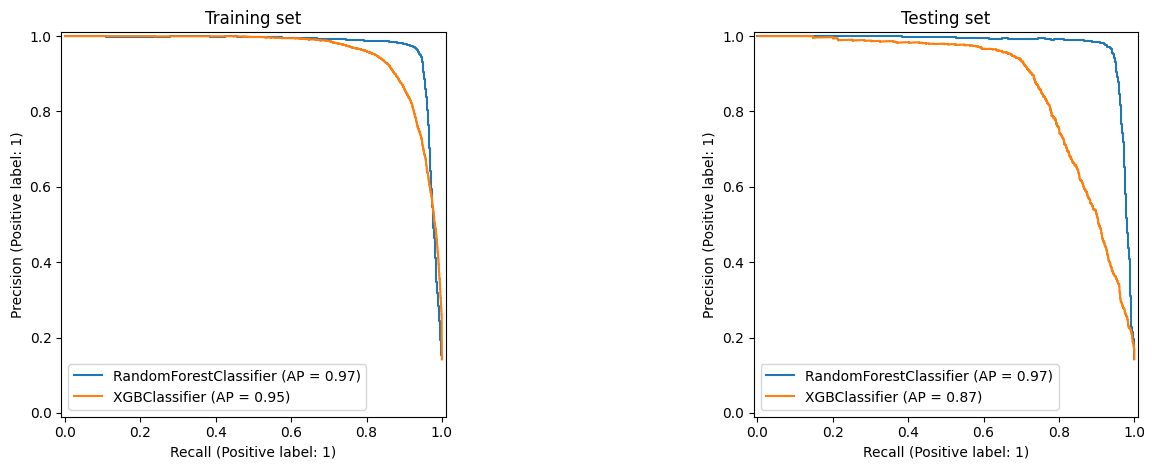

In [20]:
from sklearn.metrics import PrecisionRecallDisplay
fig,ax=plt.subplots(nrows=1,ncols=2)
fig.set_figwidth(15)

PrecisionRecallDisplay.from_estimator(rfmodel_sm,X_train,y_train,ax=ax[0])
PrecisionRecallDisplay.from_estimator(xgb,X_train,y_train,ax=ax[0])
ax[0].set_title('Training set')

PrecisionRecallDisplay.from_estimator(rfmodel_sm,X_test,y_test,ax=ax[1])
PrecisionRecallDisplay.from_estimator(xgb,X_test,y_test,ax=ax[1])
ax[1].set_title('Testing set')


plt.tight_layout()
plt.show()
